# Data

In [1]:
!git clone https://github.com/ozcelikfu/brain-diffuser.git
%cd brain-diffuser/data
!pip install awscli
# !aws s3 sync s3://natural-scenes-dataset/nsddata ./nsddata

Cloning into 'brain-diffuser'...
remote: Enumerating objects: 428, done.
remote: Counting objects: 100% (428/428), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 428 (delta 157), reused 390 (delta 132), pack-reused 0 (from 0)
Receiving objects: 100% (428/428), 6.15 MiB | 11.45 MiB/s, done.
Resolving deltas: 100% (157/157), done.
/content/brain-diffuser/data
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9.1
    Uninstalling rsa-4.9.1:
      Successfully uninstalled rsa-4.9.1
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.

In [2]:
import os
from tqdm import tqdm

print('Preparing for NSD download')
os.makedirs('nsddata/experiments/nsd', exist_ok=True)
os.makedirs('nsddata_stimuli/stimuli/nsd', exist_ok=True)

os.system('aws s3 cp --no-sign-request s3://natural-scenes-dataset/nsddata/experiments/nsd/nsd_expdesign.mat nsddata/experiments/nsd/')
print('Downloaded 1/3 experiments')

os.system('aws s3 cp --no-sign-request s3://natural-scenes-dataset/nsddata/experiments/nsd/nsd_stim_info_merged.pkl nsddata/experiments/nsd/')
print('Downloaded 2/3 experiments')

os.system('aws s3 cp --no-sign-request s3://natural-scenes-dataset/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5 nsddata_stimuli/stimuli/nsd/')
print('Downloaded 3/3 experiments')

for sub in [1]:  #  2,5,7
    os.makedirs(f'nsddata_betas/ppdata/subj{sub:02d}/func1pt8mm/betas_fithrf_GLMdenoise_RR', exist_ok=True)
    for sess in tqdm(range(1, 38)):
        os.system(
            f'aws s3 cp --no-sign-request '
            f's3://natural-scenes-dataset/nsddata_betas/ppdata/subj{sub:02d}/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session{sess:02d}.nii.gz '
            f'nsddata_betas/ppdata/subj{sub:02d}/func1pt8mm/betas_fithrf_GLMdenoise_RR/'
        )

for sub in [1]:
    os.makedirs(f'nsddata/ppdata/subj{sub:02d}/func1pt8mm/roi', exist_ok=True)
    os.system(
        f'aws s3 sync --no-sign-request '
        f's3://natural-scenes-dataset/nsddata/ppdata/subj{sub:02d}/func1pt8mm/roi/ '
        f'nsddata/ppdata/subj{sub:02d}/func1pt8mm/roi/'
    )
print('NSD download complete')

Preparing for NSD download
Downloaded 1/3 experiments
Downloaded 2/3 experiments
Downloaded 3/3 experiments


100%|██████████| 37/37 [02:51<00:00,  4.63s/it]


NSD download complete


In [3]:
print("Preparing subj 1 data")
# !python prepare_nsddata.py -sub 1
# following code is from prepare_sd_data

Preparing subj 1 data


In [4]:
%cd /content/brain-diffuser/data
import os
import numpy as np
import h5py
import scipy.io as spio
import nibabel as nib
from tqdm import tqdm

sub = 1
assert sub in [1, 2, 5, 7]

def loadmat(filename):
    def _check_keys(d):
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list

    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

print('Loading fMRI data')
stim_order_f = 'nsddata/experiments/nsd/nsd_expdesign.mat'
stim_order = loadmat(stim_order_f)

sig_train = {}
sig_test = {}
num_trials = 37*750
for idx in tqdm(range(num_trials)):
    nsdId = stim_order['subjectim'][sub-1, stim_order['masterordering'][idx]-1] - 1
    if stim_order['masterordering'][idx] > 1000:
        sig_train.setdefault(nsdId, []).append(idx)
    else:
        sig_test.setdefault(nsdId, []).append(idx)

train_im_idx = list(sig_train.keys())
test_im_idx = list(sig_test.keys())

roi_dir = f'nsddata/ppdata/subj{sub:02d}/func1pt8mm/roi/'
betas_dir = f'nsddata_betas/ppdata/subj{sub:02d}/func1pt8mm/betas_fithrf_GLMdenoise_RR/'

mask_filename = 'nsdgeneral.nii.gz'
mask = nib.load(os.path.join(roi_dir, mask_filename)).get_fdata()
num_voxel = mask[mask>0].shape[0]

fmri = np.zeros((num_trials, num_voxel), dtype=np.float32)
for i in tqdm(range(37)):
    beta_filename = f"betas_session{i+1:02d}.nii.gz"
    beta_f = nib.load(os.path.join(betas_dir, beta_filename)).get_fdata().astype(np.float32)
    fmri[i*750:(i+1)*750] = beta_f[mask>0].T
    del beta_f
print("fMRI data loaded")

/content/brain-diffuser/data


/tmp/ipython-input-2720966901.py:15: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):


Loading fMRI data


100%|██████████| 37/37 [06:40<00:00, 10.84s/it]

fMRI data loaded


In [5]:
import requests

url = "https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/COCO_73k_annots_curated.npy"
output_path = "annots/COCO_73k_annots_curated.npy"

response = requests.get(url)
response.raise_for_status()  # Check if the request was successful

with open(output_path, 'wb') as f:
    f.write(response.content)

print(f"Downloaded {output_path}")

Downloaded annots/COCO_73k_annots_curated.npy


In [6]:
f_stim = h5py.File('nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5', 'r')
stim_ds = f_stim['imgBrick']

os.makedirs(f'processed_data/subj{sub:02d}', exist_ok=True)

def process_and_save(indices, fmri_dict, prefix):
    num_samples = len(indices)
    fmri_array = np.zeros((num_samples, num_voxel), dtype=np.float32)
    stim_array = np.zeros((num_samples, 425, 425, 3), dtype=np.uint8)

    for i, idx in tqdm(enumerate(indices), total=num_samples):
        stim_array[i] = stim_ds[idx]
        fmri_array[i] = fmri[np.array(sorted(fmri_dict[idx]))].mean(0)
        # print(f"{prefix}: processed {i+1}/{num_samples}")

    np.save(f'processed_data/subj{sub:02d}/{prefix}_fmriavg_nsdgeneral_sub{sub}.npy', fmri_array)
    np.save(f'processed_data/subj{sub:02d}/{prefix}_stim_sub{sub}.npy', stim_array)
    print(f"{prefix} data saved.")

process_and_save(train_im_idx, sig_train, "nsd_train")
process_and_save(test_im_idx, sig_test, "nsd_test")

annots_cur = np.load('annots/COCO_73k_annots_curated.npy')

def save_captions(indices, prefix):
    captions_array = np.empty((len(indices), 5), dtype=annots_cur.dtype)
    for i, idx in tqdm(enumerate(indices), total=len(indices)):
        captions_array[i, :] = annots_cur[idx, :]
        # print(f"{prefix}: processed {i+1}/{len(indices)} captions")
    np.save(f'processed_data/subj{sub:02d}/{prefix}_cap_sub{sub}.npy', captions_array)
    print(f"{prefix} captions saved.")

save_captions(train_im_idx, "nsd_train")
save_captions(test_im_idx, "nsd_test")

100%|██████████| 8859/8859 [00:41<00:00, 214.02it/s]


nsd_train data saved.


100%|██████████| 982/982 [00:04<00:00, 205.35it/s]


nsd_test data saved.


100%|██████████| 8859/8859 [00:00<00:00, 173325.46it/s]


nsd_train captions saved.


100%|██████████| 982/982 [00:00<00:00, 137886.46it/s]

nsd_test captions saved.


In [7]:
print("Downloading model assets")
!wget https://openaipublic.blob.core.windows.net/very-deep-vaes-assets/vdvae-assets-2/imagenet64-iter-1600000-log.jsonl
!wget https://openaipublic.blob.core.windows.net/very-deep-vaes-assets/vdvae-assets-2/imagenet64-iter-1600000-model.th
!wget https://openaipublic.blob.core.windows.net/very-deep-vaes-assets/vdvae-assets-2/imagenet64-iter-1600000-model-ema.th
!wget https://openaipublic.blob.core.windows.net/very-deep-vaes-assets/vdvae-assets-2/imagenet64-iter-1600000-opt.th

--2025-12-08 22:17:54--  https://openaipublic.blob.core.windows.net/very-deep-vaes-assets/vdvae-assets-2/imagenet64-iter-1600000-log.jsonl
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 20.60.241.33
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|20.60.241.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145115 (142K) [application/octet-stream]
Saving to: ‘imagenet64-iter-1600000-log.jsonl’

imagenet64-iter-160 100%[===================>] 141.71K  --.-KB/s    in 0.1s    

2025-12-08 22:17:54 (952 KB/s) - ‘imagenet64-iter-1600000-log.jsonl’ saved [145115/145115]

--2025-12-08 22:17:54--  https://openaipublic.blob.core.windows.net/very-deep-vaes-assets/vdvae-assets-2/imagenet64-iter-1600000-model.th
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 20.60.241.33
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|20.60.

In [8]:
print("Extracting features")
%cd /content/brain-diffuser
!mv /content/brain-diffuser/data//imagenet64-iter-1600000-model-ema.th /content/brain-diffuser/vdvae/model/imagenet64-iter-1600000-model-ema.th
# !python scripts/vdvae_extract_features.py -sub 1

Extracting features
/content/brain-diffuser


In [9]:
%cd /content/brain-diffuser/vdvae

import sys, os
sys.path.append('/content/brain-diffuser/vdvae')

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm

# project imports
from hps import Hyperparams
from utils import maybe_download
from vae import VAE
from image_utils import *
from model_utils import *

# ---- Hardcoded parameters ----
sub = 1
batch_size = 30

# ---- Setup H params ----
H = {
    'image_size': 64,
    'image_channels': 3,
    'seed': 0,
    'port': 29500,
    'save_dir': './saved_models/test',
    'data_root': './',
    'desc': 'test',
    'hparam_sets': 'imagenet64',

    # IMPORTANT: we are already in /content/brain-diffuser/vdvae
    # so the correct paths DO NOT start with "vdvae/"
    'restore_path': 'imagenet64-iter-1600000-model.th',
    'restore_ema_path': 'model/imagenet64-iter-1600000-model-ema.th',
    'restore_log_path': 'imagenet64-iter-1600000-log.jsonl',
    'restore_optimizer_path': 'imagenet64-iter-1600000-opt.th',

    'dataset': 'imagenet64',
    'ema_rate': 0.999,
    'enc_blocks': '64x11,64d2,32x20,32d2,16x9,16d2,8x8,8d2,4x7,4d4,1x5',
    'dec_blocks': '1x2,4m1,4x3,8m4,8x7,16m8,16x15,32m16,32x31,64m32,64x12',
    'zdim': 16,
    'width': 512,
    'custom_width_str': '',
    'bottleneck_multiple': 0.25,
    'no_bias_above': 64,
    'scale_encblock': False,
    'test_eval': True,
    'warmup_iters': 100,
    'num_mixtures': 10,
    'grad_clip': 220.0,
    'skip_threshold': 380.0,
    'lr': 0.00015,
    'lr_prior': 0.00015,
    'wd': 0.01,
    'wd_prior': 0.0,
    'num_epochs': 10000,
    'n_batch': 4,
    'adam_beta1': 0.9,
    'adam_beta2': 0.9,
    'temperature': 1.0,
    'iters_per_ckpt': 25000,
    'iters_per_print': 1000,
    'iters_per_save': 10000,
    'iters_per_images': 10000,
    'epochs_per_eval': 1,
    'epochs_per_probe': None,
    'epochs_per_eval_save': 1,
    'num_images_visualize': 8,
    'num_variables_visualize': 6,
    'num_temperatures_visualize': 3,
    'mpi_size': 1,
    'local_rank': 0,
    'rank': 0,
    'logdir': './saved_models/test/log'
}

class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

H = dotdict(H)

# sanity check: make sure EMA checkpoint exists where we say it is
if not os.path.exists(H.restore_ema_path):
    raise FileNotFoundError(
        f"Expected EMA checkpoint at {H.restore_ema_path}.\n"
        "Make sure you ran wget in /content/brain-diffuser/vdvae and that:\n"
        "  imagenet64-iter-1600000-model-ema.th was moved into vdvae/model/."
    )

H, preprocess_fn = set_up_data(H)
ema_vae = load_vaes(H)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ema_vae = ema_vae.to(device)

# ---- RAM-safe dataset ----
class ExternalImageDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.data = np.load(data_path, mmap_mode='r')  # open once
        self.shape = self.data.shape

    def __getitem__(self, idx):
        img = self.data[idx]  # direct access
        img = Image.fromarray(img.astype(np.uint8))
        img = T.functional.resize(img, (64, 64))
        img = torch.tensor(np.array(img)).float()
        return img

    def __len__(self):
        return self.shape[0]

# ---- Function to extract latents incrementally and return memmap ----
def extract_latents_memmap(dataset, tmp_path, num_latents=31, batch_size=32):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                        num_workers=min(8, os.cpu_count()), pin_memory=True)

    os.makedirs(os.path.dirname(tmp_path), exist_ok=True)

    # Estimate latent size
    with torch.no_grad():
        dummy_x = next(iter(loader))
        data_input, _ = preprocess_fn(dummy_x)
        activations = ema_vae.encoder.forward(data_input)
        _, stats = ema_vae.decoder.forward(activations, get_latents=True)
        latent_dim = sum(s['z'].numel() // len(data_input) for s in stats)

    # Memory-mapped array
    latents_memmap = np.memmap(tmp_path, dtype=np.float32, mode='w+',
                               shape=(len(dataset), latent_dim))

    idx_start = 0
    from torch.cuda.amp import autocast

    for i, x in tqdm(enumerate(loader), total=len(loader)):
        x = x.to(device, non_blocking=True)
        with torch.no_grad(), autocast():
            data_input, _ = preprocess_fn(x)
            activations = ema_vae.encoder.forward(data_input)
            _, stats = ema_vae.decoder.forward(activations, get_latents=True)
            batch_latent = np.hstack(
                [s['z'].cpu().numpy().reshape(len(data_input), -1) for s in stats]
            )
            latents_memmap[idx_start:idx_start + len(data_input)] = batch_latent
            idx_start += len(data_input)

    latents_memmap.flush()
    return tmp_path

# ---- Paths ----
# NOTE: we are in /content/brain-diffuser/vdvae
# Our NSD data lives in ../data/processed_data/...
train_path = f'/content/brain-diffuser/data/processed_data/subj{sub:02d}/nsd_train_stim_sub{sub}.npy'
test_path  = f'/content/brain-diffuser/data/processed_data/subj{sub:02d}/nsd_test_stim_sub{sub}.npy'

train_dataset = ExternalImageDataset(train_path)
test_dataset  = ExternalImageDataset(test_path)

# Temporary memmap files
train_tmp = f'/content/brain-diffuser/data/extracted_features/subj{sub:02d}/train_latents.dat'
test_tmp  = f'/content/brain-diffuser/data/extracted_features/subj{sub:02d}/test_latents.dat'

# Extract latents incrementally (RAM-safe)
extract_latents_memmap(train_dataset, train_tmp, num_latents=31, batch_size=batch_size)
extract_latents_memmap(test_dataset, test_tmp, num_latents=31, batch_size=batch_size)

# Load memmap files in read mode and save as a single npz

# np.savez_compressed(
#     f'/content/brain-diffuser/data/extracted_features/subj{sub:02d}/nsd_vdvae_features_31l.npz',
#     train_latents=train_latents,
#     test_latents=test_latents
# )

/content/brain-diffuser/vdvae
Restoring ema vae from model/imagenet64-iter-1600000-model-ema.th


  0%|          | 0/296 [00:00<?, ?it/s]/tmp/ipython-input-399499893.py:144: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
100%|██████████| 33/33 [01:52<00:00,  3.40s/it]


'/content/brain-diffuser/data/extracted_features/subj01/test_latents.dat'

# Phase 1

In [20]:
import numpy as np
sub = 1
train_path = '/content/brain-diffuser/data/processed_data/subj{:02d}/nsd_train_fmriavg_nsdgeneral_sub{}.npy'.format(sub,sub)
train_fmri = np.load(train_path)
test_path = '/content/brain-diffuser/data/processed_data/subj{:02d}/nsd_test_fmriavg_nsdgeneral_sub{}.npy'.format(sub,sub)
test_fmri = np.load(test_path)

train_tmp = f'/content/brain-diffuser/data/extracted_features/subj{sub:02d}/train_latents.dat'
test_tmp  = f'/content/brain-diffuser/data/extracted_features/subj{sub:02d}/test_latents.dat'

train_latents = np.memmap(train_tmp, dtype=np.float32, mode='r').reshape(len(train_fmri), -1)
test_latents  = np.memmap(test_tmp, dtype=np.float32, mode='r').reshape(len(test_fmri), -1)

In [21]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader

# -------------------------------------------------------
# CONFIG
# -------------------------------------------------------
MAX_TRAIN = None # defaults to max number possible
MAX_TEST  = 1000
BATCH_SIZE = 8
NUM_WORKERS = 4
PIN_MEMORY = False
HIDDEN_DIM = 128
INPUT_SCALE = 300.0   # BASED ON YOUR ORIGINAL PIPELINE
CLIP_GRAD_NORM = 5.0
LR = 1e-4             # SMALLER/SAFE BUT LARGER THAN 1e-5 IF YOU WANT FASTER LEARNING
EPOCHS = 10

# -------------------------------------------------------
# RAM-SAFE DATASET (NO HEAP NORMALIZATION, BUT SCALE)
# -------------------------------------------------------
class FMRI2LatentDataset(torch.utils.data.Dataset):
    def __init__(self, fmri_path, latent_path, fmri_dim, latent_dim, max_samples=None, scale=INPUT_SCALE):
        # MEMMAPS ARE 1D ARRAYS OF FLOAT32
        self.fmri_raw = np.memmap(fmri_path, dtype=np.float32, mode='r')
        print(len(self.fmri_raw))
        self.latent_raw = np.memmap(latent_path, dtype=np.float32, mode='r')

        total = len(self.fmri_raw) // fmri_dim
        if max_samples is not None:
            total = min(total, max_samples)

        self.total = total
        self.fmri_dim = fmri_dim
        self.latent_dim = latent_dim
        self.scale = float(scale)

    def __len__(self):
        return self.total

    def __getitem__(self, idx):
        start_f = idx * self.fmri_dim
        start_l = idx * self.latent_dim

        x = np.array(self.fmri_raw[start_f:start_f + self.fmri_dim], dtype=np.float32)
        y = np.array(self.latent_raw[start_l:start_l + self.latent_dim], dtype=np.float32)

        # ZERO OUT ANY BAD VALUES
        x = np.nan_to_num(x, nan=0., posinf=0., neginf=0.)
        y = np.nan_to_num(y, nan=0., posinf=0., neginf=0.)

        # SIMPLE SCALE (LIKE YOUR ORIGINAL PIPELINE)
        if self.scale != 0:
            x = x / self.scale

        # CLAMP TO A REASONABLE RANGE TO PREVENT INF/VERY-LARGE VALUES
        x = np.clip(x, -1e3, 1e3).astype(np.float32)
        y = np.clip(y, -1e6, 1e6).astype(np.float32)

        return torch.from_numpy(x), torch.from_numpy(y)

fmri_dim = train_fmri.shape[1]
latent_dim = train_latents.shape[1]

train_ds = FMRI2LatentDataset(train_path, train_tmp, fmri_dim, latent_dim, MAX_TRAIN)
test_ds  = FMRI2LatentDataset(test_path, test_tmp, fmri_dim, latent_dim, MAX_TEST)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

class FMRI2Latent(nn.Module):
    def __init__(self, input_dim, output_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.LayerNorm(hidden),
            nn.ReLU(),
            nn.Linear(hidden, output_dim),
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # ENSURE FLOAT32
        x = x.float()
        # SAFEGUARD: REPLACE NaN/INF WITH 0 BEFORE PASSING FORWARD
        x = torch.nan_to_num(x, nan=0.0, posinf=1e6, neginf=-1e6)
        return self.net(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = FMRI2Latent(fmri_dim, latent_dim, hidden=HIDDEN_DIM).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

from tqdm import tqdm

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    batches = 0

    for xb, yb in tqdm(train_loader, desc=f"TRAIN EPOCH {epoch+1}"):
        xb = xb.to(device)
        yb = yb.to(device)

        # CHECK FOR NaNs/INFs IN INPUTS
        if torch.isnan(xb).any() or torch.isinf(xb).any():
            print("FOUND NaN/INF IN XB! CLEANING (torch.nan_to_num).")
            xb = torch.nan_to_num(xb, nan=0.0, posinf=1e6, neginf=-1e6)
        if torch.isnan(yb).any() or torch.isinf(yb).any():
            print("FOUND NaN/INF IN YB! CLEANING (torch.nan_to_num).")
            yb = torch.nan_to_num(yb, nan=0.0, posinf=1e6, neginf=-1e6)

        pred = model(xb)

        # CHECK PRED BEFORE LOSS
        if torch.isnan(pred).any() or torch.isinf(pred).any():
            print("NaN/INF IN PRED BEFORE LOSS. ZEROING PRED AND SKIPPING STEP.")
            pred = torch.nan_to_num(pred, nan=0.0, posinf=1e6, neginf=-1e6)

        loss = criterion(pred, yb)

        if torch.isnan(loss) or torch.isinf(loss):
            print("LOSS IS NaN/INF -> SKIPPING BACKWARD, printing debug stats")
            print("xb mean/std:", xb.mean().item(), xb.std().item())
            print("yb mean/std:", yb.mean().item(), yb.std().item())
            print("pred mean/std:", pred.mean().item(), pred.std().item())
            continue

        optimizer.zero_grad()
        loss.backward()

        # CHECK GRAD NaNs
        any_nan_grad = False
        for n, p in model.named_parameters():
            if p.grad is not None and (torch.isnan(p.grad).any() or torch.isinf(p.grad).any()):
                print(f"NAN/INF IN GRAD FOR {n}; ZEROING GRADS")
                p.grad = torch.nan_to_num(p.grad, nan=0.0, posinf=1e6, neginf=-1e6)
                any_nan_grad = True

        # OPTIONAL GRAD CLIP
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)

        optimizer.step()

        total_loss += loss.item()
        batches += 1

    if batches:
        print(f"Epoch {epoch+1} - Loss: {total_loss / batches:.6f}")
    else:
        print("NO BATCHES PROCESSED!")

print("TRAINING DONE")

139298948
15441000


TRAIN EPOCH 1: 100%|██████████| 1108/1108 [05:08<00:00,  3.60it/s]

Epoch 1 - Loss: 0.132982
TRAINING DONE


predicted_latent shape: (1, 1451040)
predicted_latent stats: mean 9.5006806e-05 std 0.30321205
Libs imported
Models is Loading
Restoring ema vae from /content/brain-diffuser/vdvae/model/imagenet64-iter-1600000-model-ema.th


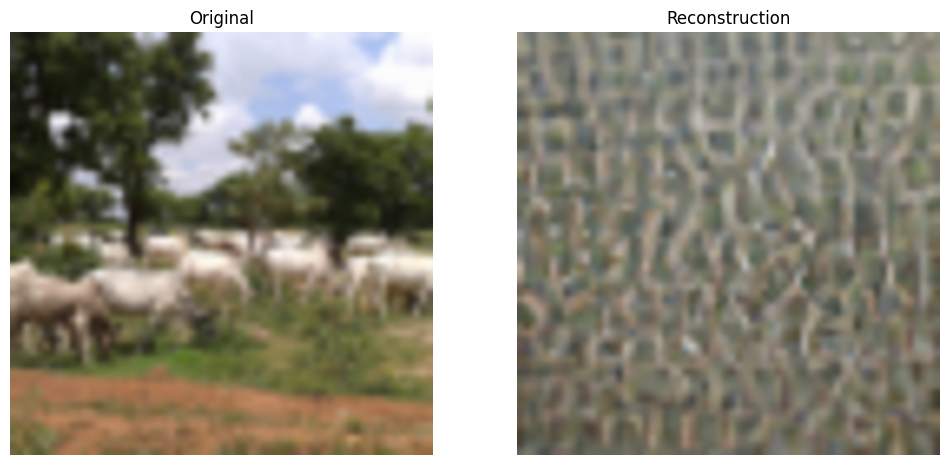

In [25]:
IMG_TO_PREDICT = 0 # change to which image to predict

model.eval()
with torch.no_grad():
    x0, _ = test_ds[IMG_TO_PREDICT]
    x0 = x0.unsqueeze(0).to(device)
    x0 = torch.nan_to_num(x0, nan=0.0, posinf=1e6, neginf=-1e6)
    predicted_latent = model(x0).cpu().numpy()

print("predicted_latent shape:", predicted_latent.shape)
print("predicted_latent stats: mean", np.nanmean(predicted_latent), "std", np.nanstd(predicted_latent))

import sys
sys.path.append('/content/brain-diffuser/vdvae')
import torch
import numpy as np
#from mpi4py import MPI
import socket
import argparse
import os
import json
import subprocess
from hps import Hyperparams, parse_args_and_update_hparams, add_vae_arguments
from utils import (logger,
                   local_mpi_rank,
                   mpi_size,
                   maybe_download,
                   mpi_rank)
from data import mkdir_p
from contextlib import contextmanager
import torch.distributed as dist
#from apex.optimizers import FusedAdam as AdamW
from vae import VAE
from torch.nn.parallel.distributed import DistributedDataParallel
from train_helpers import restore_params
from image_utils import *
from model_utils import *
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as T
import pickle

sub=1
assert sub in [1,2,5,7]
batch_size=500

print('Libs imported')

H = {'image_size': 64, 'image_channels': 3,'seed': 0, 'port': 29500, 'save_dir': './saved_models/test', 'data_root': './', 'desc': 'test', 'hparam_sets': 'imagenet64', 'restore_path': 'imagenet64-iter-1600000-model.th', 'restore_ema_path': '/content/brain-diffuser/vdvae/model/imagenet64-iter-1600000-model-ema.th', 'restore_log_path': 'imagenet64-iter-1600000-log.jsonl', 'restore_optimizer_path': 'imagenet64-iter-1600000-opt.th', 'dataset': 'imagenet64', 'ema_rate': 0.999, 'enc_blocks': '64x11,64d2,32x20,32d2,16x9,16d2,8x8,8d2,4x7,4d4,1x5', 'dec_blocks': '1x2,4m1,4x3,8m4,8x7,16m8,16x15,32m16,32x31,64m32,64x12', 'zdim': 16, 'width': 512, 'custom_width_str': '', 'bottleneck_multiple': 0.25, 'no_bias_above': 64, 'scale_encblock': False, 'test_eval': True, 'warmup_iters': 100, 'num_mixtures': 10, 'grad_clip': 220.0, 'skip_threshold': 380.0, 'lr': 0.00015, 'lr_prior': 0.00015, 'wd': 0.01, 'wd_prior': 0.0, 'num_epochs': 10000, 'n_batch': 4, 'adam_beta1': 0.9, 'adam_beta2': 0.9, 'temperature': 1.0, 'iters_per_ckpt': 25000, 'iters_per_print': 1000, 'iters_per_save': 10000, 'iters_per_images': 10000, 'epochs_per_eval': 1, 'epochs_per_probe': None, 'epochs_per_eval_save': 1, 'num_images_visualize': 8, 'num_variables_visualize': 6, 'num_temperatures_visualize': 3, 'mpi_size': 1, 'local_rank': 0, 'rank': 0, 'logdir': './saved_models/test/log'}
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
H = dotdict(H)

H, preprocess_fn = set_up_data(H)

print('Models is Loading')
ema_vae = load_vaes(H)

class batch_generator_external_images(Dataset):

    def __init__(self, data_path):
        self.data_path = data_path
        self.im = np.load(data_path).astype(np.uint8)


    def __getitem__(self,idx):
        img = Image.fromarray(self.im[idx])
        img = T.functional.resize(img,(64,64))
        img = torch.tensor(np.array(img)).float()
        #img = img/255
        #img = img*2 - 1
        return img

    def __len__(self):
        return  len(self.im)

# GET REF_LATENT FROM FIRST TEST BATCH
image_path = '/content/brain-diffuser/data/processed_data/subj{:02d}/nsd_test_stim_sub{}.npy'.format(sub,sub)
test_images = batch_generator_external_images(data_path=image_path)
testloader = DataLoader(test_images, batch_size=1, shuffle=False)

for x in testloader:
    data_input, _ = preprocess_fn(x)
    with torch.no_grad():
        activations = ema_vae.encoder.forward(data_input)
        px_z, stats = ema_vae.decoder.forward(activations, get_latents=True)
    break  # only need the first batch

ref_latent = stats

def latent_transformation(latents, ref):
    layer_dims = np.array([2**4,2**4,2**8,2**8,2**8,2**8,2**10,2**10,2**10,2**10,2**10,2**10,2**10,2**10,
                           2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,2**12,
                           2**12,2**12,2**14])
    transformed_latents = []
    for i in range(31):
        t_lat = latents[:, layer_dims[:i].sum():layer_dims[:i+1].sum()]
        c,h,w = ref[i]['z'].shape[1:]
        transformed_latents.append(t_lat.reshape(len(latents), c, h, w))
    return transformed_latents

# ----------------------
# SAMPLE FUNCTION
# ----------------------
def sample_from_hier_latents(latents, sample_ids):
    sample_ids = [id for id in sample_ids if id < len(latents[0])]
    layers_num = len(latents)
    sample_latents = []
    for i in range(layers_num):
        sample_latents.append(torch.tensor(latents[i][sample_ids]).float().cuda())
    return sample_latents

import matplotlib.pyplot as plt
from PIL import Image
import torch

input_latent = latent_transformation(predicted_latent, ref_latent)

samp = sample_from_hier_latents(input_latent, [0])  # only one image

with torch.no_grad():
    px_z = ema_vae.decoder.forward_manual_latents(len(samp[0]), samp, t=None)
    sample_from_lat = ema_vae.decoder.out_net.sample(px_z)

rec_im = sample_from_lat[0]
rec_im = Image.fromarray(rec_im)
predicted_img = rec_im
rec_im = rec_im.resize((512,512), resample=3)

orig_im = test_images[0]
if isinstance(orig_im, torch.Tensor):
    orig_im = orig_im.numpy().astype(np.uint8)
orig_im = Image.fromarray(orig_im)
orig_im = orig_im.resize((512,512), resample=3)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(orig_im)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(rec_im)
plt.title("Reconstruction")
plt.axis("off")

plt.show()


# Phase 2

In [26]:
!pip install torch
!pip install huggingface
!pip install diffusers
!pip install -U peft

In [ ]:
# PHASE 2
import torch
from diffusers import AutoPipelineForImage2Image, LCMScheduler
from diffusers.utils import make_image_grid, load_image

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

pipe = AutoPipelineForImage2Image.from_pretrained(
    "Lykon/dreamshaper-7",
    torch_dtype=torch.float16,
    variant="fp16",
)

pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
pipe.load_lora_weights("latent-consistency/lcm-lora-sdv1-5")

generator = torch.manual_seed(0)

def generate_image(prompt, init_image):
  out_image = pipe(
      prompt,
      image=init_image,
      num_inference_steps=4,
      guidance_scale=1,
      strength=0.6,
      generator=generator
  ).images[0]
  return out_image
from time import time

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

safety_checker/model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/1.72G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

In [ ]:
test_caps = np.load(f'/content/brain-diffuser/data/processed_data/subj{sub:02d}/nsd_test_cap_sub{sub}.npy', allow_pickle=True)

plt.imshow(predicted_img)
plt.axis('off')
plt.title(f"Phase 1 Output Image")
plt.show()
start_t = time()
label = test_caps[IMG_TO_PREDICT][0]
print(label)
out = generate_image(label, predicted_img) # THIS IS WHERE TO PUT PROMPT AND IMAGE FROM PHASE 1
end_t = time() - start_t
plt.imshow(out)
plt.axis('off')
plt.title(f"LCM-LoRA Output Image")
plt.show()